# Face Recognition
This notebook aims to conceive a ML model that is able to recognize and idenfity faces in near real time.

The compared models include:
* Linear Regression
* Logistic Regression
* Support Vector Machines
* Neural Networks
* Hidden Markov Models

For feature extraction we use Singular Value Decomposition

The paper for this notebook can be found at: URL

## Introduction
Face recognition has proven to be of more and more use as technology advances. Real-time identification of people, further security when unlocking personal devices or even implementing a social credit point system like in China :) Unlike face detection, which focuses on understanding where a face is on a given picture, face recognition focuses on understanding who the face in a picture belongs to; in other words, identifying people.


## Loading libraries

In [1]:
# Helper libraries
import numpy as np
import pandas as pd
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt
import re
import glob
import os

from scipy.io import loadmat

# TensorFlow and Keras
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical

## Processing the data
The dataset used for this project was the [ORL Face database](http://cam-orl.co.uk/facedatabase.html "Show me the data"). There
are 40 people in this dataset and each person has 10 images. These images have a size of 112 × 92. 112 is the height of the image and 92 is the width of the image. Each image contains only one face. 

Let us start by loading and sampling the data.

In [2]:
def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

In [26]:
# Load filenames into a list
files = [ 
       os.path.join(parent, name)
       for (parent, subdirs, files) in os.walk("data")
       for name in files + subdirs if name[-3:] == "pgm"
   ]


data = []

# Load images into a labelled matrix
for f in files:
    image = read_pgm(f)
    new_img = image.reshape((image.shape[0] * image.shape[1], 1))
    
    # Normalizing the data
    new_img = new_img / 255
    
    label = int(f.split("/")[-2][1:])

    new_img = np.append(new_img, label)

    data += [new_img]
    
    
np_data = np.array(data)

X_full = np_data.reshape(np_data.shape[0], np_data.shape[1])
np.random.shuffle(X_full)

In [4]:
X_full.shape

(410, 10305)

### Classes
Additionally, let's also load the class numbers as well as a useful macro: the image dimensions (DIMS). Since we have 41 subjects, they will merely be their indexes

In [5]:
classes = range(0, 41)
DIMS = (112, 92)

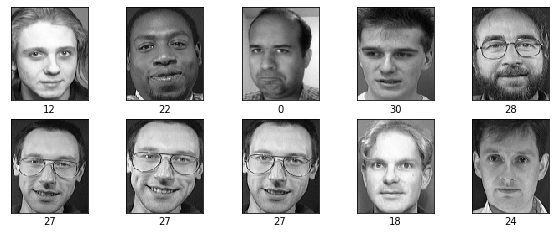

In [6]:
# Display sample_size images (with 1 < sample_size < 40)
sample_size = 10
plt.figure(figsize=(10,10))

for i in range(0, sample_size):
    idx = np.random.randint(0, 410)
    image = X_full[idx][:-1].reshape(DIMS)
    plt.subplot(5,5,i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image, plt.cm.gray)
    plt.xlabel(classes[int(X_full[idx][-1])])
    
plt.show()

# Splitting the Data into Train, Valid and Test sets

Now that we are going to try out different machine learning models, we need a validation set in order to benchmark how well different models perform against each other. That being said we will split our data into train (60%), validation (20%) and test (20%) sets.

In [27]:
# 60 20 20
ratio = [0.6, 0.2, 0.2]

train_idx = int( ratio[0] * X_full.shape[0])
valid_idx = int( train_idx + ratio[1] * X_full.shape[0])

X_train = X_full[:train_idx][:]
X_valid = X_full[train_idx:valid_idx][:]
X_test = X_full[valid_idx:][:]

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)


(246, 10305)
(82, 10305)
(82, 10305)


# Model 1: Multivariate Linear Regression
For a first approach, let us implement and test a LinReg model with a Gradient Descent optimizer.

In [8]:
def computeCost(X,y,theta):
    """
   Take the numpy arrays X, y, theta and return the cost function J for this theta. 

    """
    m=len(y)
    h= np.dot(X, theta)
    J= 1/(2*m) * np.sum(np.power((h - y),2))

    return J

In [9]:
def gradient_descent(X,y,theta,alpha,num_iters):
    """
    Take numpy arrays X, y and theta and update theta by taking num_iters gradient steps with learning rate alpha
    
     Return: theta and the list of the cost of theta (J_history) during each iteration
    """
    
    m=len(y)
    J_history=[]
    
    for i in range(num_iters):
        h = np.dot(X,theta)
        grad = np.dot(X.transpose(),(h-y)) #Vectorized way to compute all gradients simultaneously -> partial derivatives
        theta= theta - ( alpha * 1/m * grad )
        
        J_history.append(computeCost(X,y,theta))
    
    return theta, J_history

In [10]:
lin_theta = np.zeros((X_train.shape[1],1))

train_examples = X_train[:,:-1]
train_labels = X_train[:, -1]
train_labels = train_labels.reshape((train_labels.shape[0], 1))

#theta, J_history = gradient_descent(train_examples, train_labels,theta, 0.0001, 100000) # 0.07317 acc
lin_theta, lin_J_history = gradient_descent(np.append(train_examples, np.ones((X_train.shape[0], 1)), axis=1), train_labels,lin_theta, 0.0001, 100)

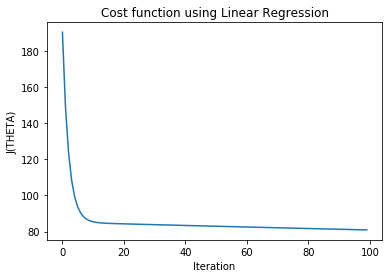

In [11]:
plt.plot(lin_J_history)
plt.title("Cost function using Linear Regression")
plt.xlabel("Iteration")
plt.ylabel("J(THETA)")
plt.show()

In [12]:
def predict(X,theta):
    """
    Takes in numpy array of x and theta and return the predicted value of y based on theta
    """
    
    h= np.dot(X, theta)
    
    return h[0]

In [13]:
# Validate and fetch an accuracy for this model
hits = 0

for v in X_valid:
    vec = np.append(v[:-1], np.ones((1, 1)))
    predicted = predict(vec, lin_theta)
    if int(predicted) == int(v[-1]):
        hits += 1
                
print("Accuracy: ", hits / X_valid.shape[0])

Accuracy:  0.012195121951219513


This performs very poorly, but it is always worth a shot. Let us now try out a Logsitic Regression Model.

# Model 2: Logistic Regression
For a second attempt, let's try to implement a Logistic function and classify different images instead of predicting a real number.

## Implementing Logistic Regression by hand

In [14]:
def sigmoid(z):
    """
    return the sigmoid of z
    """
    
    gz= 1 / (1 + np.exp(-z))
    
    return gz

In [15]:
def cost_function(theta, X, y):
    """
    Takes in numpy array theta, x and y and return the logistic regression cost function and gradient
    """
    
    #number of training examples 
    m = X.shape[0]
    
    #vector of the model predictions for all training examples   
    h = sigmoid(np.dot(X, theta))
         
    error = (-y * np.log(h)) - ((1-y)*np.log(1-h))

    #cost function
    cost = 1/m * sum(error)
       
    #vector of gradients of all model parameters theta   
    grad = 1/m * np.dot(X.transpose(),(h - y))
    
    return cost[0] , grad

In [16]:
# Inicialize vector theta = 0
initial_theta = np.zeros((X_full.shape[1], 1))

#Run costFunction
cost, grad= cost_function(initial_theta, np.append(train_examples, np.ones((X_train.shape[0], 1)), axis=1), train_labels)

In [17]:
#log_theta , log_J_history = gradient_descent(np.append(train_examples, np.ones((X_train.shape[0], 1)), axis=1), train_labels, initial_theta, 0.0001, 64000)
log_theta , log_J_history = gradient_descent(np.append(train_examples, np.ones((X_train.shape[0], 1)), axis=1), train_labels, initial_theta, 0.0001, 100)

print("Theta optimized by gradient descent:", log_theta)

print("The cost for the optimized theta:",round(log_J_history[-1],3))

Theta optimized by gradient descent: [[0.00209588]
 [0.00200648]
 [0.00210924]
 ...
 [0.00989352]
 [0.00995023]
 [0.01827344]]
The cost for the optimized theta: 80.905


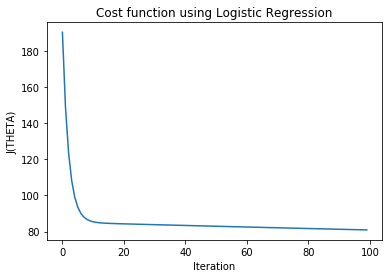

In [18]:
plt.plot(log_J_history)
plt.title("Cost function using Logistic Regression")
plt.xlabel("Iteration")
plt.ylabel("J(THETA)")
plt.show()

In [25]:
# Validate and fetch an accuracy for this model
#np.dot(np.append(X_valid[:, :-1], np.ones((82, 1)), axis=1), log_theta)

## Logistic Regression using scikit-learn

In [28]:
from sklearn.linear_model import LogisticRegression

# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

logisticRegr.fit(train_examples, train_labels)

/home/melo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/melo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/melo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
logisticRegr.predict(X_valid[0, :-1].reshape(1,-1))

array([32.])

In [41]:
predictions = logisticRegr.predict(X_valid[:, :-1])
score = logisticRegr.score(X_valid[:, :-1], X_valid[:, -1])
print(score)

0.9634146341463414


In [45]:
print(predictions[0], X_valid[:, -1][0])

32.0 32.0


# Model 3: Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC

# Instancing and training
classifier = SVC(C=1, kernel="linear")
classifier.fit(train_examples,np.ravel(train_labels))

In [48]:
# Making predictions
print(classifier.predict(X_valid[:, :-1])[0])

print(classifier.score(X_valid[:, :-1], X_valid[:, -1]))

32.0
0.9878048780487805
